In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime
import sys
import random
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# data
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# ml
sys.path.append('..')
import decisiveml as dml

/Users/lionelyoung/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Assume CL futures margin
margin = 5000

start_date = datetime.date(2016, 1, 1)
end_date = datetime.date(2018, 1, 1)

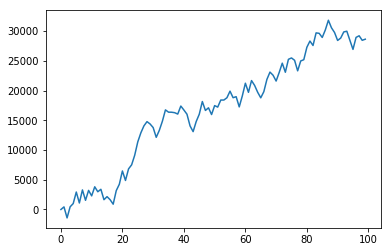

In [3]:
# We're going to generate a random list of trades,
# and you should replace this with your walkforward list of trades
trades_list = random.sample(range(-2000, 2300), 100)
cumsum = np.asarray(trades_list).cumsum()
plt.plot(cumsum)

In [4]:
# Initialize
mc = dml.MonteCarlo(trades_list)

# We will sample with replacement the number of trades per year
# so we need the start and end date to determine how many trades at in a year on average
mc.settings(margin, start_date, end_date)

# Test different levels of equity starting at this value
trial_starting_equity = int(margin * 1.5)

# Run the Monte Carlo
results = mc.run(trial_starting_equity)

In [5]:
# Put the results in a dataframe so it's nicer to look at in notebook
# Our goal is to get the highest equity below 10% Risk of Ruin
df = pd.DataFrame(index=range(1,len(results)))
count = 1
for result in results:
    df.loc[count, 'equity'] = result['equity']
    df.loc[count, 'is_ruined'] = result['is_ruined']
    df.loc[count, 'is_profitable'] = result['is_profitable']
    df.loc[count, 'returns_pct'] = result['returns_pct']
    df.loc[count, 'drawdown_pct'] = result['drawdown_pct']
    df.loc[count, 'returns_per_drawdown'] = result['returns_per_drawdown']
    count += 1

# Get the recommended values
recommended = df[df['is_ruined'] <= 10].iloc[0]
print('Recommend a starting equity of {}, which has {:0.2}% Risk-of-Ruin, \n\t{:0.0f}% Probability-of-Profit and a {:0.2f} Returns/Drawdown Ratio'.format(
                recommended['equity'], recommended['is_ruined'], 
                recommended['is_profitable'], recommended['returns_per_drawdown']))

if recommended['is_ruined'] > 10 or recommended['returns_per_drawdown'] < 2.0:
    print("Risk Assessment: FAILED")
else:
    print("Risk Assessment: PASSED")

mc_1p5x = recommended['drawdown_pct'] * 1.5
print("MC-Drawdown: {:0.1f}% MC-1.5x-DD: {:0.1f}%".format(recommended['drawdown_pct'], mc_1p5x))

profit = recommended['equity'] * recommended['returns_pct'] / 100
months = (end_date - start_date).days/30
average_monthly_net_profit = profit / months
print("Average monthly net profit: {:0.1f}".format(average_monthly_net_profit))

df

Recommend a starting equity of 11250.0, which has 9.3% Risk-of-Ruin, 
	93% Probability-of-Profit and a 4.10 Returns/Drawdown Ratio
Risk Assessment: PASSED
MC-Drawdown: 29.7% MC-1.5x-DD: 44.5%
Average monthly net profit: 558.7


,equity,is_ruined,is_profitable,returns_pct,drawdown_pct,returns_per_drawdown
1,7500.0,33.16,93.52,185.0,39.201088,4.693435
2,9375.0,17.40,93.68,150.0,33.110400,4.476294
3,11250.0,9.32,93.16,121.0,29.691326,4.098214
4,13125.0,4.44,92.48,105.0,27.161016,3.909390
5,15000.0,2.16,93.92,91.0,23.554208,3.839563
6,16875.0,1.20,93.68,82.0,22.435409,3.734907
7,18750.0,0.28,94.16,75.0,20.607606,3.563883
8,20625.0,0.24,93.92,69.0,19.005157,3.585663
9,22500.0,0.04,93.60,61.0,17.768780,3.430220
10,24375.0,0.04,92.88,57.0,16.392062,3.456624


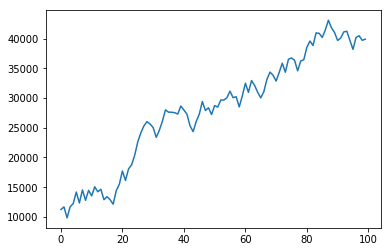

In [6]:
plt.plot(cumsum + recommended['equity'])